In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from numba import cuda

In [3]:
train_data=pd.read_csv('.gitignore/train.csv')
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
test_data=pd.read_csv('.gitignore/test.csv')
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [5]:
store_data=pd.read_csv('.gitignore/stores.csv')
store_data.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [6]:
samplesub_data=pd.read_csv('.gitignore/sample_submission.csv')
samplesub_data

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [7]:
oil_data=pd.read_csv('.gitignore/oil.csv')
oil_data.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [8]:
sales=train_data.groupby(['date','family'],as_index=False).agg(sales=('sales','sum'))
sales

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,2.000000
3,2013-01-01,BEVERAGES,810.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
55567,2017-08-15,POULTRY,17586.709986
55568,2017-08-15,PREPARED FOODS,4641.522980
55569,2017-08-15,PRODUCE,125108.971000
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,2530.000000


In [9]:
family_list=list(set(sales['family']))
family_list.sort()
family_list

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [10]:
timeseries=sales.pivot(index='date', columns='family', values='sales')
timeseries.index=pd.to_datetime(timeseries.index)
timeseries

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.090000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.00000,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.500000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.00000,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.455000,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.00000,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.209000,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.00000,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.945010,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.00000,0.0,1245.637004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,441.0,7.0,351.0,189111.0,0.0,28204.48600,870.0,55682.0,44909.0,18680.488004,...,500.0,26944.092010,15978.0,587.0,654.0,25318.297990,5199.494021,118738.14300,3523.0,1272.615997
2017-08-12,403.0,3.0,369.0,182318.0,0.0,27403.54800,849.0,57935.0,42854.0,15689.893010,...,483.0,17775.650112,15903.0,508.0,712.0,19134.510058,4573.465992,111788.35090,3644.0,1028.030006
2017-08-13,481.0,9.0,433.0,202354.0,1.0,33262.75700,544.0,61757.0,50112.0,17593.274020,...,469.0,18633.015039,18188.0,541.0,741.0,20509.265004,4941.509018,125923.80240,3718.0,1118.047000


Text(0, 0.5, 'Sales')

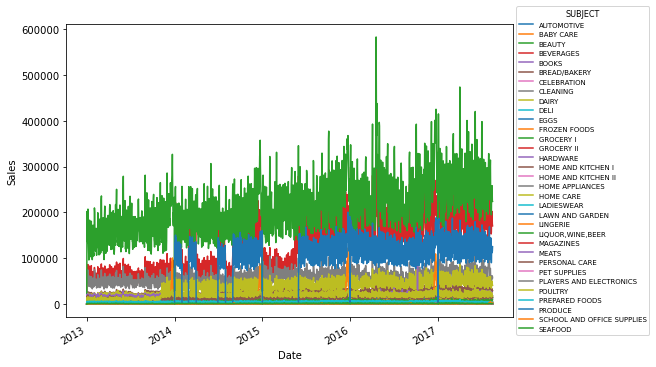

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

timeseries.plot(table=False, ax=ax);
ax.legend(title='SUBJECT',title_fontsize=8,prop={"size":7},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Sales')

In [15]:
# Taking first order differance to make time-series stationary
difference1=timeseries.diff(periods=1)
difference1=difference1[1:]

Text(0, 0.5, 'Sales')

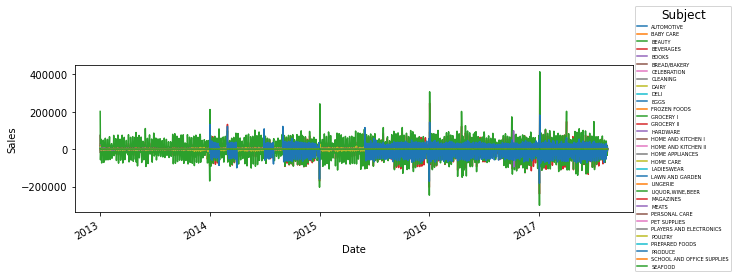

In [16]:
# Plotting first-order difference to see whether how the time series looks like
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
difference1.plot(table=False, ax=ax);
ax.legend(title='Subject',title_fontsize=12,prop={"size":5},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Sales')

In [17]:
#After first-order differance computed to be sure if whether time-series stationary, performed Augmented Dickey Fuller Test (ADF)
#Performing Augmented Dickey Fuller Test (ADF), if p values less then 0.05 we can say that time serias are stationary
for i in family_list:
    stationarty_test=adfuller(difference1[i])
    print('ADF=',stationarty_test[0],'-----','p=',stationarty_test[1],'---',i)

ADF= -13.110313085080824 ----- p= 1.6399989234827264e-24 --- AUTOMOTIVE
ADF= -12.05616313404684 ----- p= 2.5306836632180795e-22 --- BABY CARE
ADF= -14.02364417802245 ----- p= 3.534887706828185e-26 --- BEAUTY
ADF= -9.963734738540593 ----- p= 2.336601893056968e-17 --- BEVERAGES
ADF= -8.864461248504886 ----- p= 1.4530575720345984e-14 --- BOOKS
ADF= -12.729786899346829 ----- p= 9.429731032910193e-24 --- BREAD/BAKERY
ADF= -10.629608012678815 ----- p= 5.255748533776835e-19 --- CELEBRATION
ADF= -16.846717860025713 ----- p= 1.126974951991007e-29 --- CLEANING
ADF= -11.875018828704384 ----- p= 6.371072222681003e-22 --- DAIRY
ADF= -14.928786281425142 ----- p= 1.3762667661744467e-27 --- DELI
ADF= -12.074993200166848 ----- p= 2.301142908886562e-22 --- EGGS
ADF= -11.524395714947406 ----- p= 3.9684518571295996e-21 --- FROZEN FOODS
ADF= -13.277610158904283 ----- p= 7.808187316736944e-25 --- GROCERY I
ADF= -10.06312616975058 ----- p= 1.3174318251476792e-17 --- GROCERY II
ADF= -10.674763960558947 ----- 

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


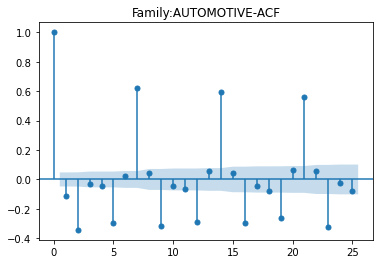

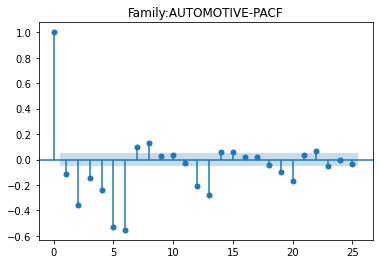

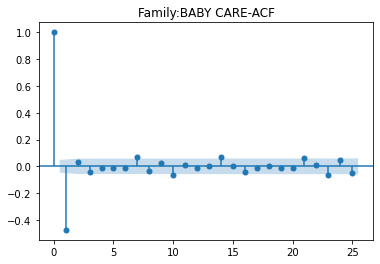

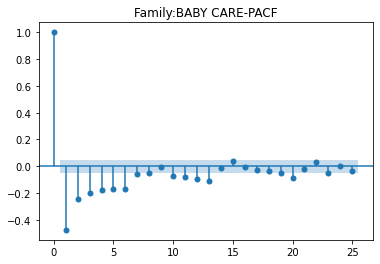

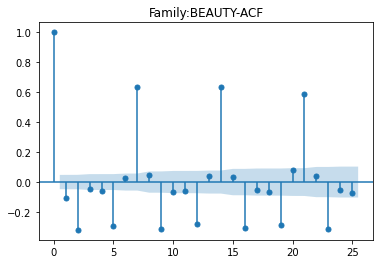

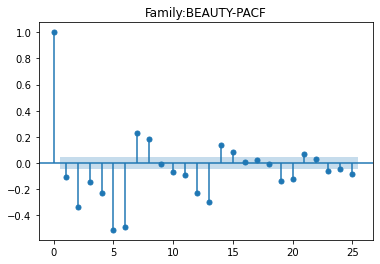

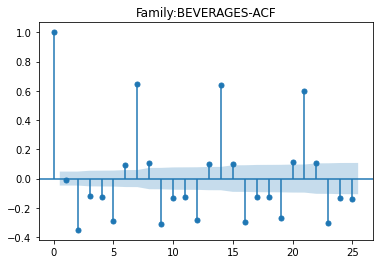

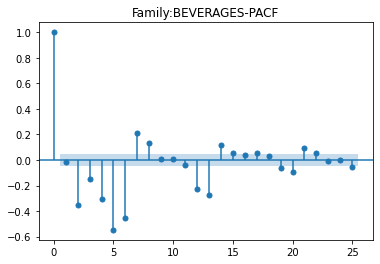

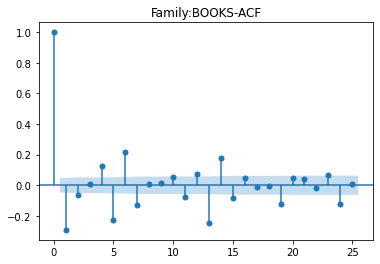

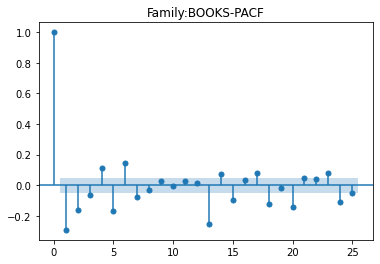

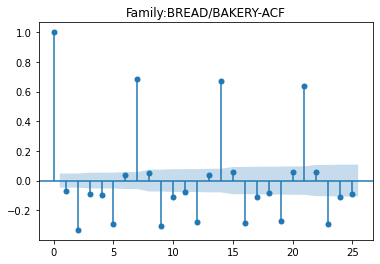

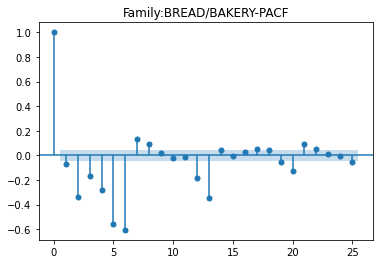

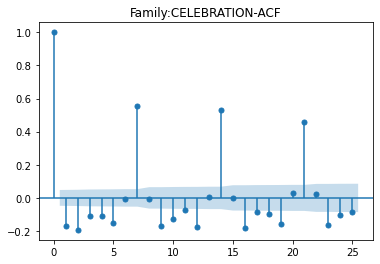

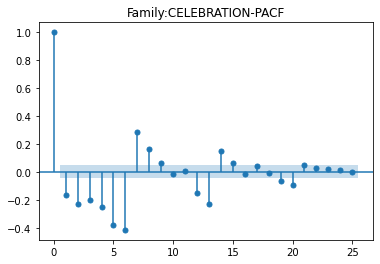

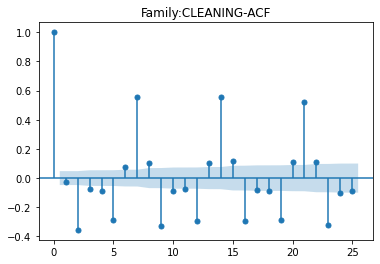

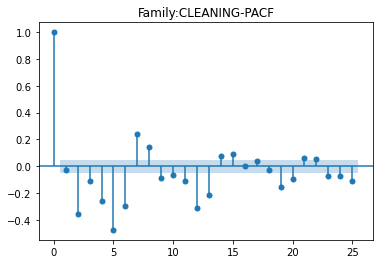

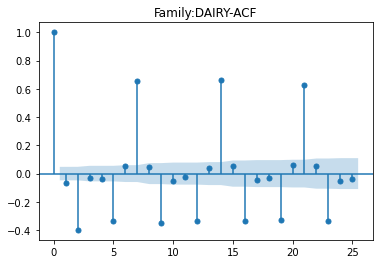

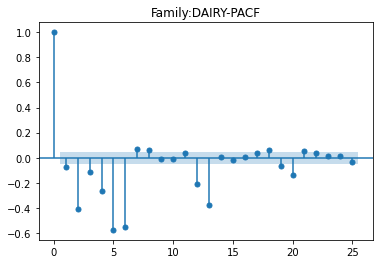

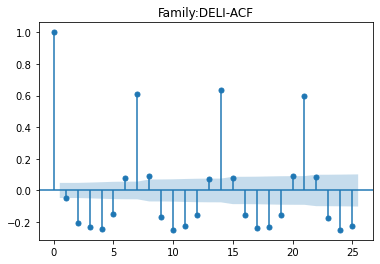

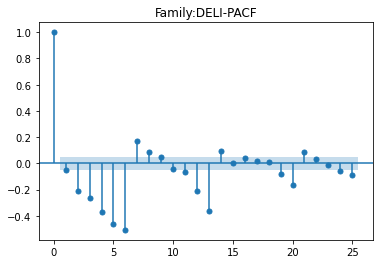

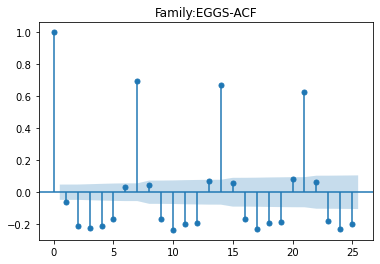

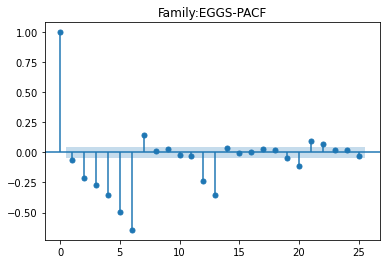

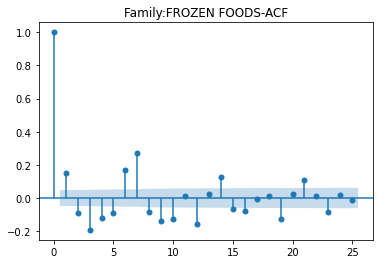

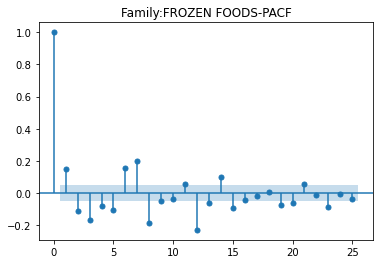

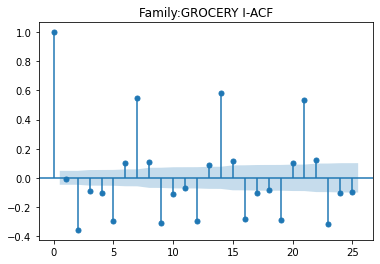

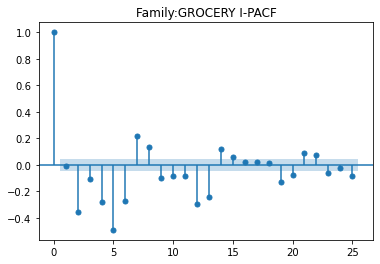

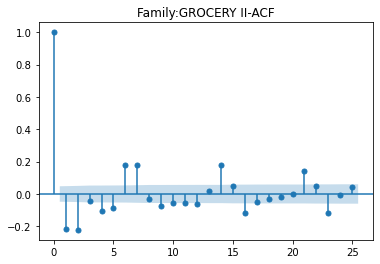

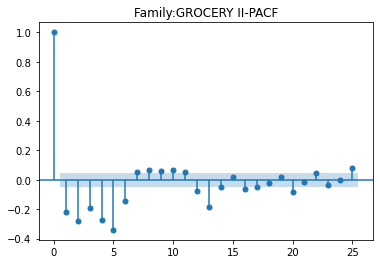

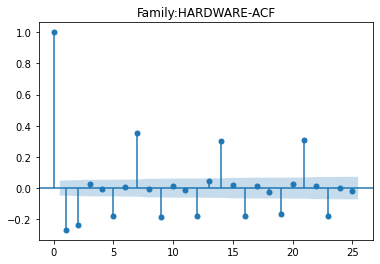

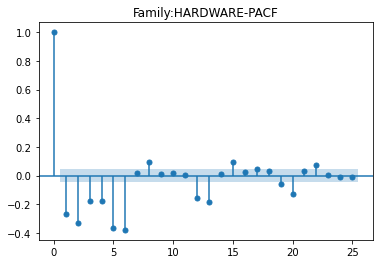

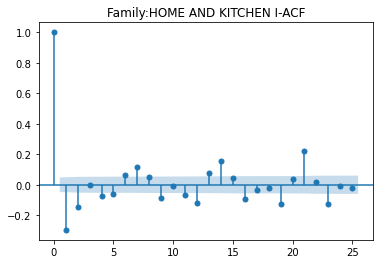

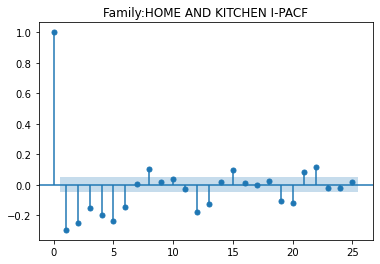

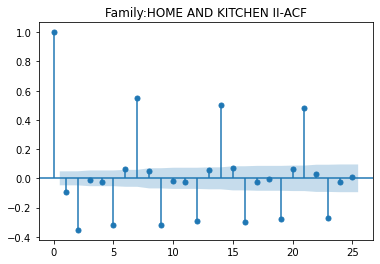

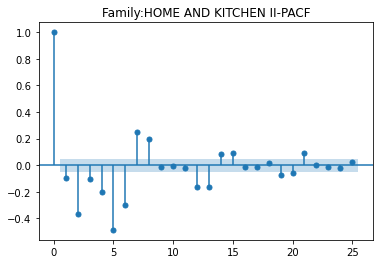

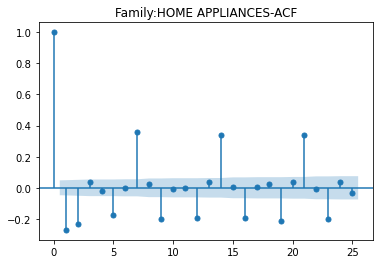

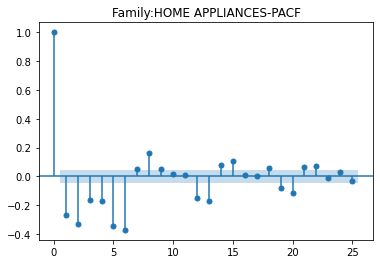

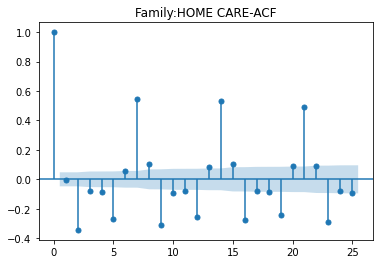

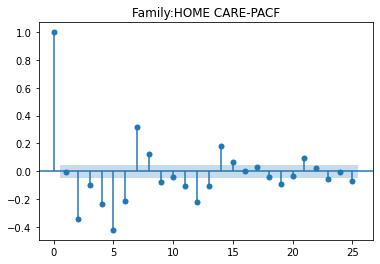

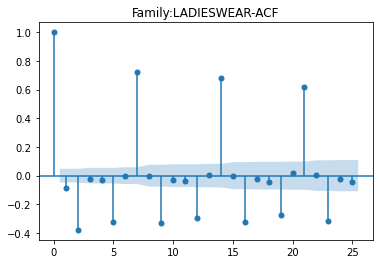

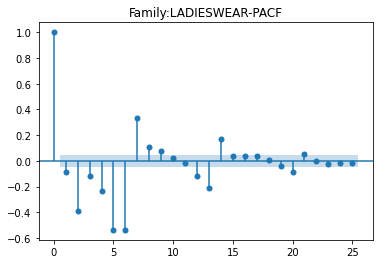

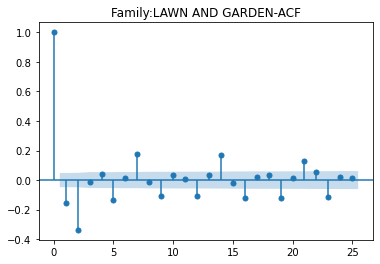

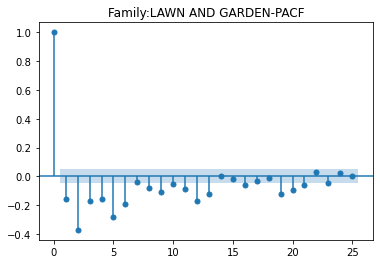

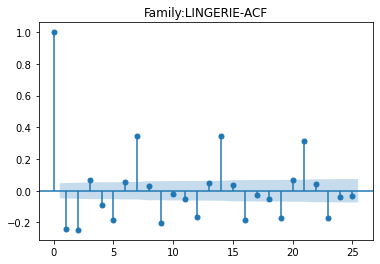

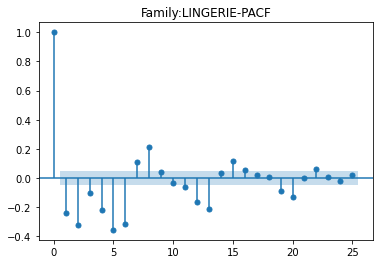

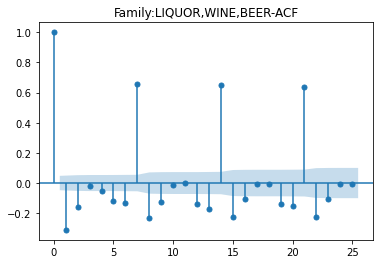

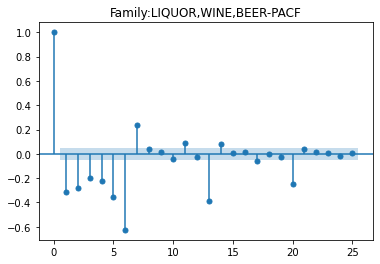

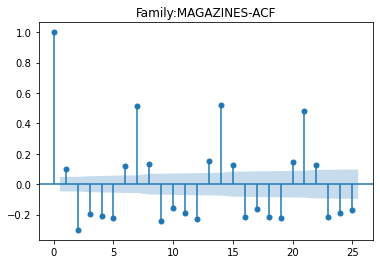

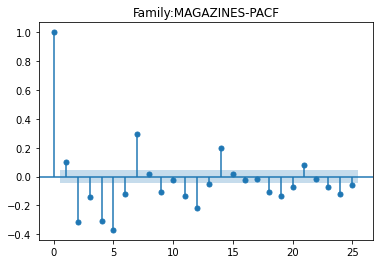

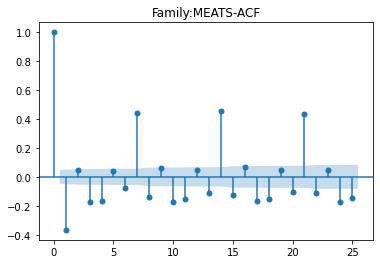

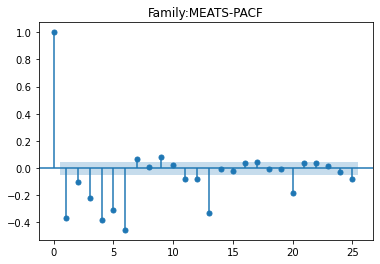

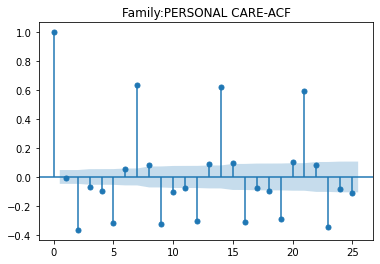

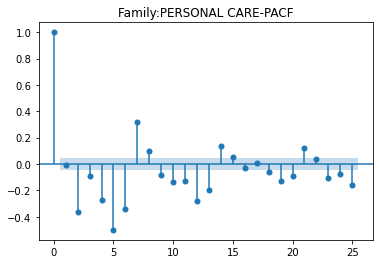

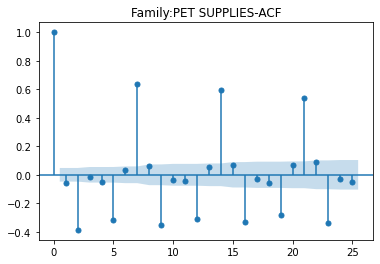

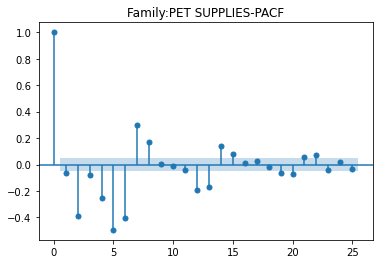

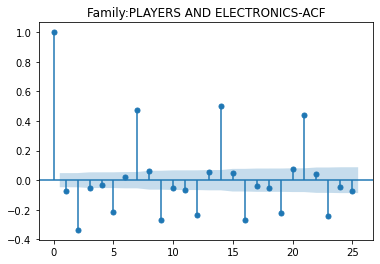

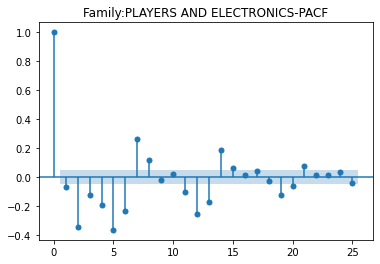

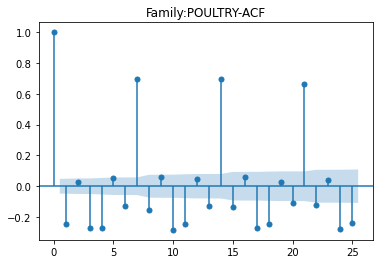

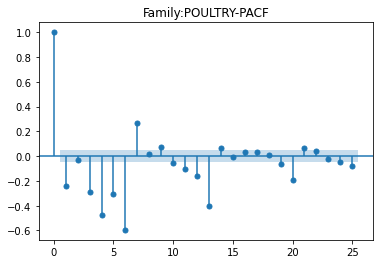

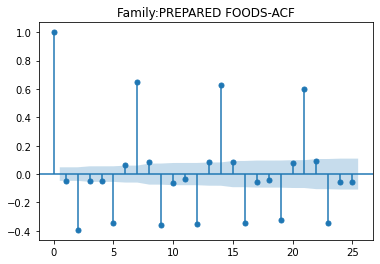

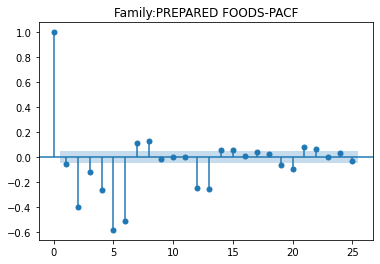

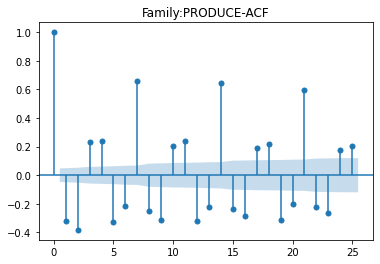

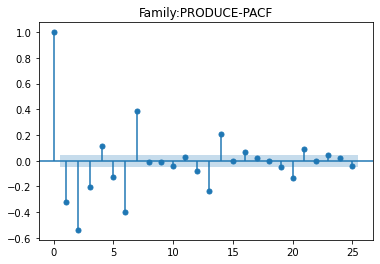

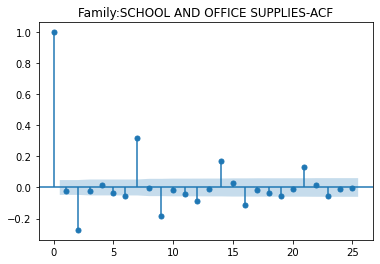

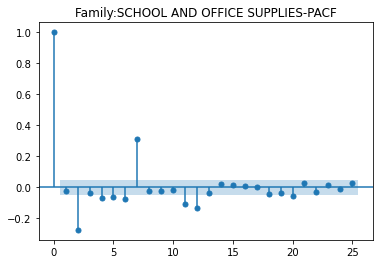

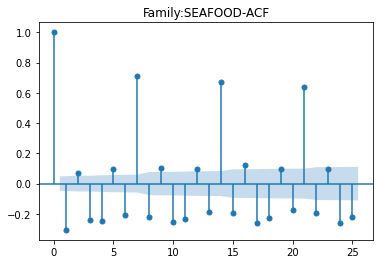

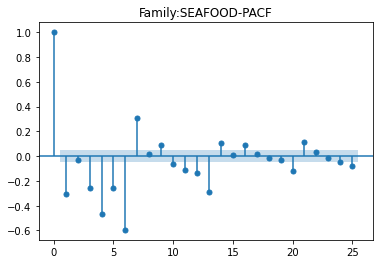

In [18]:
# Plotting Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF)
for i in family_list:
    plot_acf(difference1[i], lags=25);
    plt.title('Family:'+str(i)+'-ACF')
    plot_pacf(difference1[i], lags=25);
    plt.title('Family:'+str(i)+'-PACF')

In [19]:
# After ACF and PACF plotted, it is hard to find standart ARIMA model for all the categories(Families)
# For this reason , decided to comput auto_arima which finds the best individual model for each category
train = timeseries.loc['2013-01-01':'2016-12-01']
test = timeseries.loc['2017-01-01':]

# Demonstration of the auto_arima for only AUTOMOTIVE category
stepwise_model = auto_arima(train['AUTOMOTIVE'], start_p=1, start_q=1,
                           max_p=5, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18480.986, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17827.364, Time=1.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18475.107, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17538.888, Time=2.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=17546.063, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17194.918, Time=4.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=17676.720, Time=1.26 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=16.67 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.73 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=17136.266, Time=6.02 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

In [20]:
stepwise_model.fit(train['AUTOMOTIVE'])

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [22]:
future_forecast = stepwise_model.predict(n_periods=227)
# This returns an array of predictions:
future_predic=pd.DataFrame(future_forecast,columns=['Prediction'])
future_predic=future_predic.round(decimals=1)

In [23]:
plot_df=pd.DataFrame(test['AUTOMOTIVE'])
plot_df['PREDICTION']=future_predic.values
plot_df

,AUTOMOTIVE,PREDICTION
date,,
2017-01-01,5.0,320.8
2017-01-02,620.0,246.6
2017-01-03,448.0,415.4
2017-01-04,369.0,449.5
2017-01-05,342.0,241.0
...,...,...
2017-08-11,441.0,226.6
2017-08-12,403.0,183.1
2017-08-13,481.0,109.9


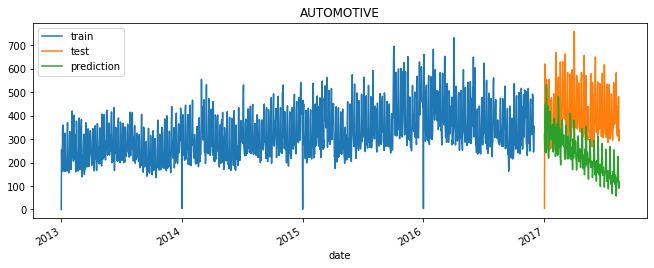

In [28]:
# Demonstration graph for AUTOMOTIVE category after ARIMA model used for prediction
fig, ax = plt.subplots(figsize=(11, 4))
train['AUTOMOTIVE'].plot(ax=ax, label='train')
test['AUTOMOTIVE'].plot(ax=ax, label='test')
plot_df['PREDICTION'].plot(ax=ax, label='prediction')
ax.set_title('AUTOMOTIVE')
ax.legend();

In [163]:
# Applying auto_arima to all the categories and saving the results in the prediction data frame
real_prediction_df=pd.DataFrame()
forecast_number=int(len(test_data)/len(family_list))
        
for i in family_list:
    stepwise_model_real= auto_arima(timeseries[i], start_p=1, start_q=1,
                               max_p=5, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    future_forecast = stepwise_model_real.predict(n_periods=forecast_number)
    # This returns an array of predictions:
    real_prediction_df['Pred-'+i]=pd.DataFrame(future_forecast)
    print(i)
#     future_predic=future_predic.round(decimals=1)

AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


In [164]:
real_prediction_df.to_csv('ARIMA_Prediction.csv')

In [165]:
real_prediction_df

,Pred-AUTOMOTIVE,Pred-BABY CARE,Pred-BEAUTY,Pred-BEVERAGES,Pred-BOOKS,Pred-BREAD/BAKERY,Pred-CELEBRATION,Pred-CLEANING,Pred-DAIRY,Pred-DELI,...,Pred-MAGAZINES,Pred-MEATS,Pred-PERSONAL CARE,Pred-PET SUPPLIES,Pred-PLAYERS AND ELECTRONICS,Pred-POULTRY,Pred-PREPARED FOODS,Pred-PRODUCE,Pred-SCHOOL AND OFFICE SUPPLIES,Pred-SEAFOOD
0,349.826083,9.653206,323.134828,173168.886596,-0.833109,30274.418521,526.423831,56040.544023,41445.947036,15945.083852,...,408.393126,22388.468795,15093.884470,323.965019,536.668785,22685.547397,4571.800838,134543.453952,3034.633425,1142.922736
1,246.060521,11.804424,327.357998,157484.088260,-1.376382,29022.130015,807.486484,48572.927503,40616.729793,14669.785246,...,463.413897,19975.832033,13753.786173,372.485093,453.167471,19143.287348,4502.978312,106472.510076,3362.261213,943.575658
2,363.522568,9.359232,345.199067,148084.582485,-0.660082,26958.257222,861.866720,40069.222746,33138.034825,14426.229165,...,549.113314,19605.756969,12566.233130,473.526378,591.623630,21224.618620,3992.270748,104587.313534,3573.737769,1066.195803
3,358.837221,8.879891,328.612700,150011.636636,-0.220875,26763.021933,776.168639,42188.494459,35495.586191,15477.412957,...,590.272240,19238.055279,12402.528377,518.613060,734.053480,18968.551994,4233.467150,138103.664427,3050.721141,820.177694
4,375.201597,11.277148,425.044078,173191.465228,-0.102448,27486.122768,861.741255,56920.783481,36480.333877,14974.494784,...,542.085786,15696.177307,14666.717305,505.437434,739.849808,18406.285350,4477.823040,109522.699781,3023.420544,911.724551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,-1215.236350,-49.899225,1150.016668,-489151.666267,-57.446568,37366.241338,29.347656,-371437.597443,-160041.551264,-22179.762112,...,6584.052952,-24707.314833,-29978.735673,-178.770924,591.778247,-5721.504833,-1976.252599,-138855.470521,73597.261846,-1153.808306
860,-1286.734869,-50.669028,1109.438524,-521721.150560,-58.255981,34447.665831,52.819317,-379323.626696,-164908.300304,-25220.936506,...,6595.942938,-30353.339152,-32393.720043,-300.790728,510.407581,-9905.606320,-2556.169363,-154599.288777,73513.478463,-1349.801499
861,-1223.124270,-50.646524,1138.703281,-505790.571020,-58.232137,36867.345411,75.231419,-372411.104908,-162329.910379,-23864.716974,...,6662.750115,-28646.984758,-30018.484731,-241.935412,604.102734,-8014.803685,-2408.807236,-145614.936418,73920.935483,-1275.446984
862,-1292.858127,-49.796242,1103.778057,-517567.569943,-57.686188,34425.753831,80.249724,-379658.847932,-163760.553047,-24788.362250,...,6684.797177,-28265.370763,-31303.173182,-256.238644,545.384456,-8718.308647,-2432.939137,-132708.795215,73683.635480,-1336.246665


In [204]:
family_prediction_list=real_prediction_df.columns
submassion_list=[]
for i in range(len(real_prediction_df)):
    for k in family_prediction_list:
        if real_prediction_df[k][i]<0:
            submassion_list.append(0)  #Making negative values zero
        else:
            submassion_list.append('{:.0f}'.format(real_prediction_df[k][i]))

In [205]:
sub_format=pd.DataFrame(samplesub_data['id'].values,columns=['id'],index=None)
sub_format['sales']=pd.DataFrame(submassion_list,columns=['sales'])
sub_format

,id,sales
0,3000888,350
1,3000889,10
2,3000890,323
3,3000891,173169
4,3000892,0
...,...,...
28507,3029395,0
28508,3029396,0
28509,3029397,0
28510,3029398,73439


In [206]:
sub_format.to_csv('OUTPUT3.csv')